In [2]:
# so kernel doesn't have to be restarted
%load_ext autoreload
%autoreload 2

# sklearn imports
from sklearn.neighbors import NearestNeighbors, KNeighborsTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imodels imports
from imodels import get_clean_dataset
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI

# data getters
from ucimlrepo import fetch_ucirepo
import openml

# local feature importance
import shap
import lime

# helper scripts
from knn_helper import *

In [3]:
data_id = 361062
k = 3
nbr_dist = "l2"
cfact_dist = "l2"
labels = "preds"

In [4]:
shap_distances = np.loadtxt(f"results/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
lime_distances = np.loadtxt(f"results/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
lmdi_distances = np.loadtxt(f"results/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")

SHAP - Mean: 4.918721305526203 Median: 4.077591885700345
LIME - Mean: 5.6965205794631 Median: 4.472285771600491
LMDI - Mean: 4.7296934824865104 Median: 3.971575512429866


/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


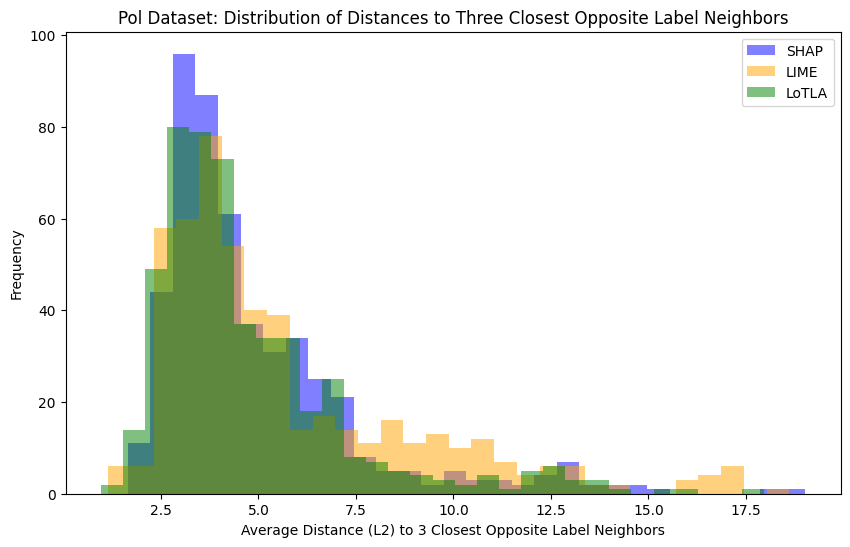

In [5]:
# print means and medians of each:
print("SHAP - Mean:", np.mean(shap_distances), "Median:", np.median(shap_distances))
print("LIME - Mean:", np.mean(lime_distances), "Median:", np.median(lime_distances))
print("LMDI - Mean:", np.mean(lmdi_distances), "Median:", np.median(lmdi_distances))

# plot distances
plt.figure(figsize=(10, 6))
plt.hist(shap_distances, bins=30, alpha=0.5, label='SHAP', color='blue')
plt.hist(lime_distances, bins=30, alpha=0.5, label='LIME', color='orange')
plt.hist(lmdi_distances, bins=30, alpha=0.5, label='LoTLA', color='green')
plt.xlabel('Average Distance (L2) to 3 Closest Opposite Label Neighbors')
plt.ylabel('Frequency')
plt.title('Pol Dataset: Distribution of Distances to Three Closest Opposite Label Neighbors')
plt.legend()
plt.show()

In [10]:
number_mean_wins = 0
number_median_wins = 0
number_tries = 0
over_shap = []
over_lime = []
for data_id in [43, 9978, 361062, 361063, 361069, 361071]:
    for k in [1, 3, 5, 7, 9]:
        for nbr_dist in ["l1", "l2"]:
            for cfact_dist in ["l1", "l2"]:
                shap_distances = np.loadtxt(f"results/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
                lime_distances = np.loadtxt(f"results/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
                lmdi_distances = np.loadtxt(f"results/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
                # print means and medians of each:
                means = {
                    "shap": np.mean(shap_distances),
                    "lime": np.mean(lime_distances),
                    "lmdi": np.mean(lmdi_distances)
                }
                medians = {
                    "shap": np.median(shap_distances),
                    "lime": np.median(lime_distances),
                    "lmdi": np.median(lmdi_distances)
                }
                
                over_shap.append(means["shap"]-means["lmdi"])
                over_lime.append(means["lime"]-means["lmdi"])
                
                if means["lmdi"] < means["shap"] and means["lmdi"] < means["lime"]:
                    number_mean_wins += 1
                if medians["lmdi"] < medians["shap"] and medians["lmdi"] < medians["lime"]:
                    number_median_wins += 1
                number_tries += 1

print("Number of Wins for LMDI (Mean):", number_mean_wins)
print("Number of Wins for LMDI (Median):", number_median_wins)
print("Number of Tries:", number_tries)
print("Percentage of Wins for LMDI (Mean):", number_mean_wins / number_tries)
print("Percentage of Wins for LMDI (Median):", number_median_wins / number_tries)            


Number of Wins for LMDI (Mean): 116
Number of Wins for LMDI (Median): 116
Number of Tries: 120
Percentage of Wins for LMDI (Mean): 0.9666666666666667
Percentage of Wins for LMDI (Median): 0.9666666666666667


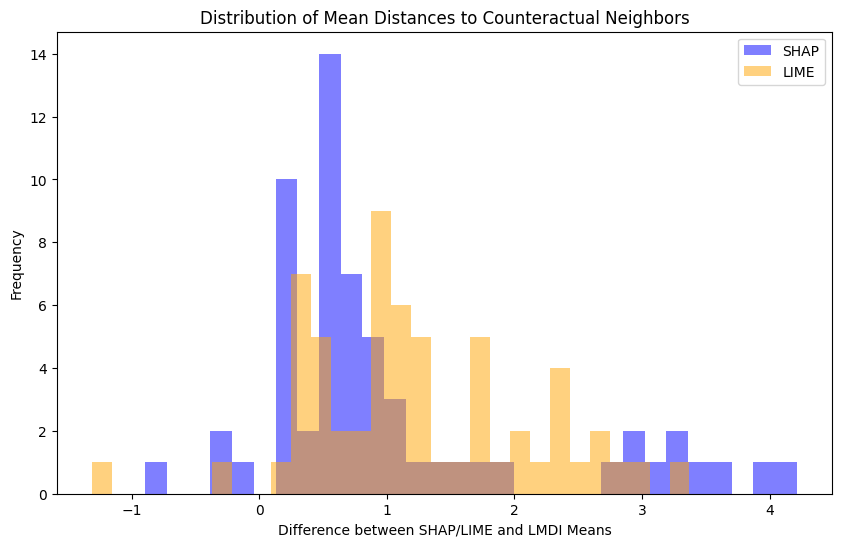

In [7]:
# plot distribution of over_shap and over_lime
plt.figure(figsize=(10, 6))
plt.hist(over_shap, bins=30, alpha=0.5, label='SHAP', color='blue')
plt.hist(over_lime, bins=30, alpha=0.5, label='LIME', color='orange')
plt.xlabel('Difference between SHAP/LIME and LMDI Means')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Distances to Counteractual Neighbors')
plt.legend()
plt.show()